In [1]:
import json
import numpy as np
from numpy.linalg import norm
from tkinter import *
from tkinter import messagebox as mb
from DataProcess import Text_To_Speech, read_Questions_and_Choices
from playsound import playsound
from threading import Thread
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from IRT import *
from utils import plot_ICC
from Recommendation_Algorithms_Data_Generation import *

In [2]:
# Open Json file and read data
with open('Data/data.json', 'r', encoding="utf-8") as handle:
    Data = json.load(handle)

# Check the one of data
testConversation = list(Data[10325].keys())[0]
print(testConversation)
testConversation = list(Data[10325].values())[0]
print(testConversation)

# Delete 10325

M: For years, many of us have relied on antibiotic use to treat various infections. And the reality is that antibiotics have been responsible for saving millions of lives since penicillin, one of the earliest antibiotics, was first used on a clinical basis 70 years ago. However, today is a new era in which taking antibiotics can cause some very dangerous and potentially life-threatening situations. With such a large life-threatening epidemic, it is sad to say that only 1. 2 percent of budgetary money for the National Institutes of Health is currently being spent on research to tackle this problem. This is a far cry from the funds necessary for a problem of such magnitude.
[{'What do we learn about the “superbugs”? Q': {"A. They are new species of big insects. ***B. They are overprescribed antibiotics. ***C. They are life-threatening diseases. ***D. They are antibiotic-resistant bacteria. ', 'A. Antibiotics are now in short supply. ***B. Many infections are no longer curable. ***C. Larg

In [3]:
# print(len(list(Data)))

In [4]:
# # Set a output path
# outputPath = "Data/Conversation mp3/test.mp3" 
# oneData = Data[1625]
# # Call the functions from another python file and split questions, choices, answers.
# questions, choices, trueAnswers = read_Questions_and_Choices(oneData)

# # Convert text into speech
# Text_To_Speech(oneData, outputPath)


In [5]:
# print(choices)

In [6]:
# Define a class to design a GUI to do the quiz
class Quiz:
    def __init__(self, quizWindow, questions, choices, trueAnswers, mp3Path):
        # Pass Questions, Choices, trueAnswers, mp3Path to class
        self.questions = questions
        self.choices = choices
        self.trueAnswers = trueAnswers
        self.outputPath = mp3Path
        self.quizWindow = quizWindow
        
        # Set the question nunmber and next question number, which will used to locate the questions
        self.questionNum= 0 
        self.questionNextNum = 1
        
        # Set 2 button states, which can make the button disable
        self.stateNextBack = NORMAL
        self.stateAudio = NORMAL
        self.nextOrSubmit = 0
        self.quit = 0
        
        # Audio repeat times used to control audio play time limitation. Correct use to computer the score of quiz.
        # To save all answer user choosen ,it will be used in IRT.
        self.audioRepeatTimes = 1
        self.correct = 0
        self.selectedAnswers = [None]*len(self.questions)

        
        # Those are some functions used to implement GUI
        self.questionStr = StringVar()
        self.ques = self.question(self.questionNum)
        self.detailsExplanation()
        self.opt_selected = StringVar()
        self.opts = self.radiobtns(self.questionNum)
        self.display_options(self.questionNum)
        self.buttons()


    # This function used to dispaly questions one by one.
    def question(self, questionNum):
        # Set a title
        title = Label(self.quizWindow, text="Quiz in Listening Comprehension", width=50, bg="blue", fg="white", font=("times", 20, "bold"))
        title.place(x=0, y=2)
       
        # Use the question string variale to store different questions.
        # Then use the Label function to display it in GUI
        self.questionStr.set(str(self.questionNextNum)+". "+self.questions[questionNum])
        questionText = Label(self.quizWindow, textvariable = self.questionStr, width=60, font=("times", 16, "bold"), anchor="w")
        questionText.place(x=70, y=150)
        return questionText

    # This function used to dispaly some explanation of Questions, 
    # which conrtains number of questions and the tips for audio play times limitation
    def detailsExplanation(self):
        
        # Tip for number of questions
        quesNumTips = "In this Audio, will involved " + str(len(self.questions)) + " questions."
        questionNumTips = Label(self.quizWindow, text = quesNumTips, fg='blue', width=60, font=("times", 16, "bold"), anchor="w")
        questionNumTips.place(x=70, y=120)
        
        # Tip for audio play times limitation
        audNumTips = "Each audio, just \n can be play twice"
        audioNumTips = Label(self.quizWindow, text = audNumTips, width=14, bg = "red", font=("times", 16, "bold"), anchor="w")
        audioNumTips.place(x=600, y=200)         
    
    # This funcrion use to play the mp3 file
    def audio(self):
        # play mp3 sound
        playsound(self.outputPath)
        
        # Set a play times count, if over 2times, the audio play bitton will disable
        self.audioRepeatTimes += 1
        if self.audioRepeatTimes == 3:
            self.stateAudio = DISABLED
            self.buttons()
    
    # To keep other button still work when the audio is playing, so set a backgroud.
    def audioBackgroug(self):
        t = Thread(target=self.audio)
        t.start()
    
    # This function will be used to set some choices. There are A, B, C three choices
    def radiobtns(self, questionNum):
        b = []
        yp = 200
        if len(self.choices[questionNum]) == 3:
            for val in ['A', 'B', 'C']:
                btn = Radiobutton(self.quizWindow, text=" ", variable=self.opt_selected, value=val, font=("times", 14))
                b.append(btn)
                btn.place(x=100, y=yp)
                yp += 40
        elif len(self.choices[questionNum]) == 4:
            for val in ['A', 'B', 'C', 'D']:
                btn = Radiobutton(self.quizWindow, text=" ", variable=self.opt_selected, value=val, font=("times", 14))
                b.append(btn)
                btn.place(x=100, y=yp)
                yp += 40            
        return b
    
    # Show all choices content
    def display_options(self, questionNum):
        
        # Through the index of questions to show all chouices corresponding to this questions
        val = 0
        self.opt_selected.set(0)
        self.ques['text'] = self.questions[questionNum]
        for op in self.choices[questionNum]:
            self.opts[val]['text'] = op
            val += 1

    # Set 4 buttons to run the GUI, stateNextBack use to control the Back and Next button available or not, 
    # stateAudio use to control audio play button
    def buttons(self):
        # This is Next button or submit button
        if len(self.questions) == 1:
            self.nextOrSubmit = 1
            
        # A button state controled by the nextOrSubmit variable.
        # When you do the last question, the next botton will become submit.
        if self.nextOrSubmit == 0:
            nextButton = Button(self.quizWindow, text="Next",command=self.nextbtn, width=12,bg="green",fg="white",font=("times",16,"bold"))
            nextButton.place(x=200,y=380)
            nextButton['state'] = self.stateNextBack
        elif self.nextOrSubmit == 1:
            nextButton = Button(self.quizWindow, text="Submit Section",command=self.nextbtn, width=12,bg="green",fg="white",font=("times",16,"bold"))
            nextButton.place(x=200,y=380)
            nextButton['state'] = self.stateNextBack           
        
        # Back button
        backButton = Button(self.quizWindow, text="Back",command=self.backbtn, width=10,bg="green",fg="white",font=("times",16,"bold"))
        backButton.place(x=20,y=380)
        backButton['state'] = self.stateNextBack

        # Quit button
        quitButton = Button(self.quizWindow, text="Quit Section", command=self.quitTest,width=10,bg="red",fg="white", font=("times",16,"bold"))
        quitButton.place(x=380,y=380)
        
        #Audio play button
        audioButton = Button(self.quizWindow, text="Audio", command=self.audioBackgroug,width=10,bg="blue",fg="white", font=("times",16,"bold"))
        audioButton.place(x=620,y=70)        
        audioButton['state'] = self.stateAudio
    
    # Save all choices made by tester
    def saveAns(self, questionNum):
        self.selectedAnswers[questionNum] = self.opt_selected.get()
    
    # Set a quit signal
    def quitTest(self):
        self.quit = 1
        self.quizWindow.destroy()
    
    # Next botton function, it will change the index number of questions, so it can turn into next questions.
    # If the questions is the last one.
    def nextbtn(self):
        # Save all answera made by user.
        # Change the questionn index
        self.saveAns(self.questionNum)
        self.questionNum += 1
        self.questionNextNum += 1
        
        # if this question is last one, so the next button will become submit
        if self.questionNum >= len(self.questions) - 1:
            self.nextOrSubmit = 1
            self.buttons()
        else:
            self.nextOrSubmit = 0
            self.buttons()
        # if tester submit quiz, Next and Back botton will disable and return the score the user get.
        # If not last question, go into next question
        if self.questionNum == len(self.questions):
            self.display_result()
            self.stateNextBack = DISABLED
            self.buttons()
        else:
            self.questionStr.set(str(self.questionNextNum)+". "+self.questions[self.questionNum])
            self.display_options(self.questionNum)       
    
    # Function use to go back to last question
    def backbtn(self):
        # This will chech the question number if is begger than 1. If the question is first question., 
        # the back button can clike but not work
        if self.questionNextNum > 1:
            self.questionNum -= 1
            self.questionNextNum -= 1
        # This will change the sSubmit button to Next botton            
        if self.questionNum >= len(self.questions) - 1:
            self.nextOrSubmit = 1
            self.buttons()
        else:
            self.nextOrSubmit = 0
            self.buttons()
            
        self.questionStr.set(str(self.questionNextNum)+". "+self.questions[self.questionNum])
        self.display_options(self.questionNum)         
    
    # Show the score of user   
    def display_result(self):
        correctIndex = []
        wrongIndex = []
        # Check all answer user made and check it right or not
        for i, answer in enumerate(self.selectedAnswers):
            if answer == self.trueAnswers[i]:
                self.correct += 1
                correctIndex.append(i+1)
            else:
                wrongIndex.append(i+1)
        # Compute the score in percentage
        score = int(self.correct / len(self.questions) * 100)
        result = "Score: " + str(score) + "%"
        # To show the right answer and wrong answer
        wc = len(self.questions) - self.correct
        correct = "No. of correct answers: " + str(self.correct)
        wrong = "No. of wrong answers: " + str(wc)
        # To show the index of right and wrong answer.
        correctIndices = "The index of correct answer: " + str(correctIndex)
        wrongIndices = "The index of wrong answer: " + str(wrongIndex)
        
        mb.showinfo("Result", "\n".join([result, correct, wrong, correctIndices, wrongIndices]))
        return self.selectedAnswers

In [7]:
# Define a class to design a GUI to do the quiz
class Recommendation_Questions:
    def __init__(self, quizWindow, questions, choices, trueAnswers, mp3Path):
        # Pass Questions, Choices, trueAnswers, mp3Path to class
        self.questions = questions
        self.choices = choices
        self.trueAnswers = trueAnswers
        self.outputPath = mp3Path
        self.quizWindow = quizWindow
        
        # Set the question nunmber and next question number, which will used to locate the questions
        self.questionNum= 0 
        self.questionNextNum = 1
        
        # Set 2 button states, which can make the button disable
        self.stateNextBack = NORMAL
        self.stateAudio = NORMAL
        self.nextOrSubmit = 0
        self.quit = 0
        
        # Audio repeat times used to control audio play time limitation. Correct use to computer the score of quiz.
        # To save all answer user choosen ,it will be used in IRT.
        self.correct = 0
        self.selectedAnswers = [None]*len(self.questions)
        self.display = False
        
        # Those are some functions used to implement GUI
        self.questionStr = StringVar()
        self.trueAnswerStr = StringVar()
        self.ques = self.question(self.questionNum)
        self.detailsExplanation()
        self.opt_selected = StringVar()
        self.opts = self.radiobtns(self.questionNum)
        self.display_options(self.questionNum)
        self.buttons()
        self.display_correct_options()


    # This function used to dispaly questions one by one.
    def question(self, questionNum):
        # Set a title
        title = Label(self.quizWindow, text="Reocmmendation of Listening Comprehension Questions", 
                      width=50, bg="blue", fg="white", font=("times", 20, "bold"))
        title.place(x=0, y=2)
       
        # Use the question string variale to store different questions.
        # Then use the Label function to display it in GUI
        self.questionStr.set(str(self.questionNextNum)+". "+self.questions[questionNum])
        questionText = Label(self.quizWindow, textvariable = self.questionStr, width=60, font=("times", 16, "bold"), anchor="w")
        questionText.place(x=70, y=150)
        return questionText

    # This function used to dispaly some explanation of Questions, 
    # which conrtains number of questions and the tips for audio play times limitation
    def detailsExplanation(self):
        
        # Tip for number of questions
        quesNumTips = "In this Audio, will involved " + str(len(self.questions)) + " questions."
        questionNumTips = Label(self.quizWindow, text = quesNumTips, fg='blue', width=60, font=("times", 16, "bold"), anchor="w")
        questionNumTips.place(x=70, y=120)
        
#         # Tip for audio play times limitation
#         audNumTips = "Each audio, just \n can be play twice"
#         audioNumTips = Label(self.quizWindow, text = audNumTips, width=14, bg = "red", font=("times", 16, "bold"), anchor="w")
#         audioNumTips.place(x=600, y=200)         
    
    # This funcrion use to play the mp3 file
    def audio(self):
        # play mp3 sound
        playsound(self.outputPath)
        
        # Set a play times count, if over 2times, the audio play bitton will disable
#         self.audioRepeatTimes += 1
#         if self.audioRepeatTimes == 3:
#             self.stateAudio = DISABLED
#             self.buttons()
    
    # To keep other button still work when the audio is playing, so set a backgroud.
    def audioBackgroug(self):
        t = Thread(target=self.audio)
        t.start()
    
    # This function will be used to set some choices. There are A, B, C three choices
    def radiobtns(self, questionNum):
        b = []
        yp = 200
        if len(self.choices[questionNum]) == 3:
            for val in ['A', 'B', 'C']:
                btn = Radiobutton(self.quizWindow, text=" ", variable=self.opt_selected, value=val, font=("times", 14))
                b.append(btn)
                btn.place(x=100, y=yp)
                yp += 40
        elif len(self.choices[questionNum]) == 4:
            for val in ['A', 'B', 'C', 'D']:
                btn = Radiobutton(self.quizWindow, text=" ", variable=self.opt_selected, value=val, font=("times", 14))
                b.append(btn)
                btn.place(x=100, y=yp)
                yp += 40            
        return b
    
    # Show all choices content
    def display_options(self, questionNum):
        
        # Through the index of questions to show all chouices corresponding to this questions
        val = 0
        self.opt_selected.set(0)
        self.ques['text'] = self.questions[questionNum]
        for op in self.choices[questionNum]:
            self.opts[val]['text'] = op
            val += 1
    
    def display_correct_options(self):
        
        if self.display:
            self.trueAnswerStr.set("True Answer: "+self.trueAnswers[self.questionNum])
        else:
            self.trueAnswerStr.set("")
        questionText = Label(self.quizWindow, textvariable = self.trueAnswerStr, fg='green', width=60, font=("times", 16, "bold"), anchor="w")
        questionText.place(x=620, y=250)   
    
    # Set 4 buttons to run the GUI, stateNextBack use to control the Back and Next button available or not, 
    # stateAudio use to control audio play button
    def buttons(self):
        # This is Next button or submit button
        if len(self.questions) == 1:
            self.nextOrSubmit = 1
            
        # A button state controled by the nextOrSubmit variable.
        # When you do the last question, the next botton will become submit.
        if self.nextOrSubmit == 0:
            nextButton = Button(self.quizWindow, text="Next",command=self.nextbtn, width=12,bg="green",fg="white",font=("times",16,"bold"))
            nextButton.place(x=200,y=380)
            nextButton['state'] = self.stateNextBack
        elif self.nextOrSubmit == 1:
            nextButton = Button(self.quizWindow, text="Submit Section",command=self.nextbtn, width=12,bg="green",fg="white",font=("times",16,"bold"))
            nextButton.place(x=200,y=380)
            nextButton['state'] = self.stateNextBack           
        
        # Back button
        backButton = Button(self.quizWindow, text="Back",command=self.backbtn, width=10,bg="green",fg="white",font=("times",16,"bold"))
        backButton.place(x=20,y=380)
        backButton['state'] = self.stateNextBack

        # Quit button
        quitButton = Button(self.quizWindow, text="Quit Section", command=self.quitTest,width=10,bg="red",fg="white", font=("times",16,"bold"))
        quitButton.place(x=380,y=380)
        
        # Audio play button
        audioButton = Button(self.quizWindow, text="Audio", command=self.audioBackgroug,width=10,bg="blue",fg="white", font=("times",16,"bold"))
        audioButton.place(x=620,y=70)  
        
        audioButton['state'] = self.stateAudio
        
        
        # Show the correct answers
        if self.display == False:
            answerButton = Button(self.quizWindow, text="Show Answer", command=self.display_correct_options_btn,width=10,bg="pink",fg="white", font=("times",16,"bold"))
            answerButton.place(x=620,y=200)         
        elif self.display == True:
            answerButton = Button(self.quizWindow, text="Hide Answer", command=self.display_correct_options_btn,width=10,bg="pink",fg="white", font=("times",16,"bold"))
            answerButton.place(x=620,y=200)             
        answerButton['state'] = self.stateNextBack
        
    # Save all choices made by tester
    def saveAns(self, questionNum):
        self.selectedAnswers[questionNum] = self.opt_selected.get()
    
    def display_correct_options_btn(self):
        if self.display == False:
            self.display = True
            self.display_correct_options()
        else:
            self.display = False
            self.display_correct_options()
        
        self.buttons()
            
    # Set a quit signal
    def quitTest(self):
        self.quit = 1
        self.quizWindow.destroy()
    
    # Next botton function, it will change the index number of questions, so it can turn into next questions.
    # If the questions is the last one.
    def nextbtn(self):
        # Save all answera made by user.
        # Change the questionn index
        self.saveAns(self.questionNum)
        self.questionNum += 1
        self.questionNextNum += 1
        
        # if this question is last one, so the next button will become submit
        if self.questionNum >= len(self.questions) - 1:
            self.nextOrSubmit = 1
            self.buttons()
        else:
            self.nextOrSubmit = 0
            self.buttons()
        # if tester submit quiz, Next and Back botton will disable and return the score the user get.
        # If not last question, go into next question
        if self.questionNum == len(self.questions):
            self.display_result()
            self.stateNextBack = DISABLED
            self.buttons()
        else:
            self.questionStr.set(str(self.questionNextNum)+". "+self.questions[self.questionNum])
            self.display_options(self.questionNum)
            self.display = False
            self.display_correct_options()
    
    # Function use to go back to last question
    def backbtn(self):
        # This will chech the question number if is begger than 1. If the question is first question., 
        # the back button can clike but not work
        if self.questionNextNum > 1:
            self.questionNum -= 1
            self.questionNextNum -= 1
        # This will change the sSubmit button to Next botton            
        if self.questionNum >= len(self.questions) - 1:
            self.nextOrSubmit = 1
            self.buttons()
        else:
            self.nextOrSubmit = 0
            self.buttons()
            
        self.questionStr.set(str(self.questionNextNum)+". "+self.questions[self.questionNum])
        self.display_options(self.questionNum)   
        self.display = False
        self.display_correct_options()
        
    # Show the score of user   
    def display_result(self):
        correctIndex = []
        wrongIndex = []
        # Check all answer user made and check it right or not
        for i, answer in enumerate(self.selectedAnswers):
            if answer == self.trueAnswers[i]:
                self.correct += 1
                correctIndex.append(i+1)
            else:
                wrongIndex.append(i+1)
        # Compute the score in percentage
        score = int(self.correct / len(self.questions) * 100)
        result = "Score: " + str(score) + "%"
        # To show the right answer and wrong answer
        wc = len(self.questions) - self.correct
        correct = "No. of correct answers: " + str(self.correct)
        wrong = "No. of wrong answers: " + str(wc)
        # To show the index of right and wrong answer.
        correctIndices = "The index of correct answer: " + str(correctIndex)
        wrongIndices = "The index of wrong answer: " + str(wrongIndex)
        
        mb.showinfo("Result", "\n".join([result, correct, wrong, correctIndices, wrongIndices]))
        return self.selectedAnswers

In [8]:
# recommendationWindow = Tk()
# recommendationWindow.geometry("800x500")
# recommendationWindow.title("Listening Conorehension Quiz")

# Recommdation = Recommendation_Questions(quizWindow=recommendationWindow, questions=questions, choices=choices, trueAnswers=trueAnswers, mp3Path=outputPath)
# userAnswer = Recommdation.selectedAnswers
# recommendationWindow.mainloop()
# print(userAnswer)

In [9]:
# manyQuestions = []
# manyChoices = []
# manyTrueAnswers = []
# manyOutputPath = []

# for i in range(3):
#     # Set a output path
#     outputPath = "Data/Conversation mp3/test" + str(i) + ".mp3"
#     oneData = Data[i]
#     # Call the functions from another python file and split questions, choices, answers.
#     questions, choices, trueAnswers = read_Questions_and_Choices(oneData)
#     manyQuestions.append(questions)
#     manyChoices.append(choices)
#     manyTrueAnswers.append(trueAnswers)
#     manyOutputPath.append(outputPath)
#     # Convert text into speech
#     Text_To_Speech(oneData, outputPath)

# print(len(manyQuestions))
# print(manyChoices[0])
    

In [10]:
def data_to_GUI(indices):
    
    manyQuestions = []
    manyChoices = []
    manyTrueAnswers = []
    manyOutputPath = []
    
    for i in indices:
        # Set a output path
        outputPath = "Data/Conversation mp3/index" + str(i) + ".mp3"
        oneData = Data[i]
        # Call the functions from another python file and split questions, choices, answers.
        questions, choices, trueAnswers = read_Questions_and_Choices(oneData)
        manyQuestions.append(questions)
        manyChoices.append(choices)
        manyTrueAnswers.append(trueAnswers)
        manyOutputPath.append(outputPath)
        # Convert text into speech
        Text_To_Speech(oneData, outputPath)
    
    return  manyQuestions, manyChoices, manyTrueAnswers, manyOutputPath

In [11]:
# class ListeningComprehensionApp(Tk):
     
#     # __init__ function for class tkinterApp
#     def __init__(self, manyQuestions, manyChoices, manyTrueAnswers, manyOutputPath, *args, **kwargs):
        
#         # __init__ function for class Tk
#         Tk.__init__(self, *args, **kwargs)

#         # creating a container
#         container = Frame(self, width=800, height=500)
#         container.pack(fill = None, expand = False)

#         # Set min frame size
#         container.grid_rowconfigure(0, minsize=500, weight = 1)
#         container.grid_columnconfigure(0, minsize=800, weight = 1)
  
#         # initializing frames to an empty array
#         self.frames = {} 

#         self.answers = []
        
#         # iterating through a tuple consisting
#         # of the different page layouts
#         for i, F in enumerate((Material_1, Material_2, Material_3)):
            
#             frame = F(container, self, manyQuestions[i], manyChoices[i], 
#                            manyTrueAnswers[i], manyOutputPath[i])
  
#             # initializing frame of that object from
#             # startpage, page1, page2 respectively with
#             # for loop
#             self.frames[F] = frame
  
#             frame.grid(row = 0, column = 0, sticky ="nsew")
  
#         self.show_frame(Material_1)

#     # to display the current frame passed as
#     # parameter
#     def show_frame(self, cont):
#         frame = self.frames[cont]
#         frame.tkraise()
    
#     def destroy_frames(self):
#         for cont in (Material_1, Material_2, Material_3):
#             self.answers.append(self.frames[cont].oneSegmentAnswer)
# #         print(self.frames[Material_1].oneSegmentAnswer)
#         print(self.answers)
#         self.destroy()
           
        
# class Material_1(Frame):
    
#     def __init__(self, parent, controller, oneQuestions, oneChoices, oneTrueAnswers, oneOutputPath):
#         Frame.__init__(self, parent)

#         oneMaterial = Quiz(quizWindow=self, questions=oneQuestions, choices=oneChoices, 
#                            tureAnswers=oneTrueAnswers, mp3Path=oneOutputPath)
        
#         self.oneSegmentAnswer = oneMaterial.selectedAnswers
        
#         if oneMaterial.quit == 1:
#             print("oneMaterial.quit")
#             lambda : controller.destroy_frames()
        
#         button1 = Button(self, text ="Back Material", 
#                          command = lambda : controller.show_frame(Material_1),
#                          width=10,bg="green",fg="white",font=("times",16,"bold"))
     
#         # putting the button in its place by
#         # using grid
#         button1.place(x=620,y=300)
#         button1.config(state=DISABLED)

#         ## button to show frame 2 with text layout2
#         button2 = Button(self, text ="Next Material", 
#                          command = lambda : controller.show_frame(Material_2),
#                          width=10,bg="green",fg="white",font=("times",16,"bold"))
     
#         # putting the button in its place by
#         # using grid
#         button2.place(x=620,y=350)
  
#         button3 = Button(self, text ="Quit Quiz", 
#                          command = lambda : controller.destroy_frames(),
#                          width=10,bg="red",fg="white",font=("times",16,"bold"))
        
#         button3.place(x=620,y=400)

    
# class Material_2(Frame):
     
#     def __init__(self, parent, controller, oneQuestions, oneChoices, oneTrueAnswers, oneOutputPath):
         
#         Frame.__init__(self, parent)

#         oneMaterial = Quiz(quizWindow=self, questions=oneQuestions, choices=oneChoices, 
#                            tureAnswers=oneTrueAnswers, mp3Path=oneOutputPath)

#         self.oneSegmentAnswer = oneMaterial.selectedAnswers
        
#         if oneMaterial.quit == 1:
#             print("oneMaterial.quit")
#             lambda : controller.destroy_frames()
            
#         # button to show frame 2 with text
#         # layout2
#         button1 = Button(self, text ="Back Material",
#                             command = lambda : controller.show_frame(Material_1),
#                             width=10,bg="green",fg="white",font=("times",16,"bold"))
     
#         # putting the button in its place
#         # by using place
#         button1.place(x=620,y=300)
        
#         # button to show frame 2 with text
#         # layout2
#         button2 = Button(self, text ="Next Material",
#                             command = lambda : controller.show_frame(Material_3),
#                             width=10,bg="green",fg="white",font=("times",16,"bold"))
        
#         # putting the button in its place by
#         # using place
#         button2.place(x=620,y=350)

#         button3 = Button(self, text ="Quit Quiz", 
#                          command = lambda : controller.destroy_frames(),
#                          width=10,bg="red",fg="white",font=("times",16,"bold"))
        
#         button3.place(x=620,y=400)

        
# # Third window frame page2
# class Material_3(Frame):
#     def __init__(self, parent, controller, oneQuestions, oneChoices, oneTrueAnswers, oneOutputPath):
#         Frame.__init__(self, parent)
        
#         oneMaterial = Quiz(quizWindow=self, questions=oneQuestions, choices=oneChoices, 
#                            tureAnswers=oneTrueAnswers, mp3Path=oneOutputPath)
        
#         self.oneSegmentAnswer = oneMaterial.selectedAnswers 
        
            
#         # button to show frame 2 with text
#         # layout2
#         button1 = Button(self, text ="Back Material",
#                          command = lambda : controller.show_frame(Material_2),
#                          width=10,bg="green",fg="white",font=("times",16,"bold"))
     
#         # putting the button in its place by
#         # using place
#         button1.place(x=620,y=300)
  
#         # button to show frame 3 with text
#         # layout3
#         button2 = Button(self, text ="Next Material",
#                          command = lambda : controller.show_frame(Material_1),
#                          width=10,bg="green",fg="white",font=("times",16,"bold"))
     
#         # putting the button in its place by
#         # using place
#         button2.place(x=620,y=350)
#         button2.config(state=DISABLED)
        
#         button3 = Button(self, text ="Quit Quiz", 
#                          command = lambda : controller.destroy_frames(),
#                          width=10,bg="red",fg="white",font=("times",16,"bold"))
        
#         button3.place(x=620,y=400)



        
# # Driver Code
# app = ListeningComprehensionApp(manyQuestions=manyQuestions, manyChoices=manyChoices, 
#                                 manyTrueAnswers=manyTrueAnswers, manyOutputPath=manyOutputPath)

# app.mainloop()

In [12]:
class ListeningComprehensionApp(Tk):
     
    # __init__ function for class tkinterApp
    def __init__(self, manyQuestions, manyChoices, manyTrueAnswers, manyOutputPath, Recommendation, LastPart, *args, **kwargs):
        
        # __init__ function for class Tk
        Tk.__init__(self, *args, **kwargs)

        self.title("Listening Compresension Quiz")
        # creating a container
        container = Frame(self, width=800, height=500)
        container.pack(fill = None, expand = False)

        # Set min frame size
        container.grid_rowconfigure(0, minsize=500, weight = 1)
        container.grid_columnconfigure(0, minsize=800, weight = 1)
  
        # initializing frames to an empty array
        self.frames = {} 
        self.frameIndex = 0
        self.resultCont = container
        
        self.manyQuestions = manyQuestions
        self.manyChoices = manyChoices
        self.manyTrueAnswers = manyTrueAnswers
        self.manyOutputPath = manyOutputPath
        
        self.materialLen = len(self.manyOutputPath)
        self.totalQuesNum = sum(len(q) for q in self.manyQuestions)
        
        self.answers = []
        
        self.buttonControl = 0
        self.Index = 0
        self.lastpart = LastPart
        # iterating through a tuple consisting
        # of the different page layouts
        for i in range(len(self.manyQuestions)):
            
            if i == 0:
                self.buttonControl = 1
            elif i == (len(self.manyQuestions) - 1):
                self.buttonControl = 2
            else:
                self.buttonControl = 0
                
            self.frameIndex = i+1
            if Recommendation == False:
                frame = Materials(container, self, self.manyQuestions[i], self.manyChoices[i], 
                                  self.manyTrueAnswers[i], self.manyOutputPath[i])
            else:
                frame = RecommendationMaterials(container, self, self.manyQuestions[i], self.manyChoices[i], 
                                  self.manyTrueAnswers[i], self.manyOutputPath[i])                
                
            # initializing frame of that object from
            # startpage, page1, page2 respectively with
            # for loop
            self.frames[i] = frame

#             if i == len(manyQuestions) - 1:
#                 frame = Results(container, self, manyTrueAnswers)
#                 self.frames[i+1] = frame
            
            frame.grid(row = 0, column = 0, sticky ="nsew")
        
        self.show_frame(index=0)

    # to display the current frame passed as
    # parameter
    def show_frame(self, index):
        frame = self.frames[index]
        frame.tkraise()
    
    def destroy_frames(self):
#         for index in range(len(manyQuestions)):
#             self.answers.append(self.frames[index].oneSegmentAnswer)
#         print(self.answers)
        self.destroy()
    
    def submit_frames(self):
        for index in range(len(self.manyQuestions)):
            self.answers.append(self.frames[index].oneSegmentAnswer)
            self.frames[index].destroy()
            
#         print(self.answers)             
        frame = Results(parent = self.resultCont, controller = self, TrueAnswers = self.manyTrueAnswers, selected_answers = self.answers)
        self.frames[len(self.manyQuestions)] = frame
            
        frame.grid(row = 0, column = 0, sticky ="nsew")
        self.show_frame(index=len(self.manyQuestions))    
    
    def indexDown(self):
        self.Index -= 1

    def indexUp(self):
        self.Index += 1
    
    def getAnswer(self):
        return self.answers
        
class Materials(Frame):
    
    def __init__(self, parent, controller, oneQuestions, oneChoices, oneTrueAnswers, oneOutputPath):
        Frame.__init__(self, parent)

        textTips1 = "In this Quiz, you will finish " + str(controller.materialLen) + " listening materials, \n" + "you have total " + str(controller.totalQuesNum) + " questions"
        
        text1 = Label(self, text = textTips1, width=40, fg='blue', font=("times", 16, "bold"), anchor="w")
        text1.place(x=70, y=50)

        textTips2 = "A." + str(controller.frameIndex) + ":"
        
        text2 = Label(self, text = textTips2, width=40, fg='green', font=("times", 16, "bold"), anchor="w")
        text2.place(x=27, y=120)
        
        oneMaterial = Quiz(quizWindow=self, questions=oneQuestions, choices=oneChoices, 
                           trueAnswers=oneTrueAnswers, mp3Path=oneOutputPath)
        
        self.oneSegmentAnswer = oneMaterial.selectedAnswers
        self.quizFlag = oneMaterial.quit
        
        button1 = Button(self, text ="Back Material", 
                         command = lambda : [controller.show_frame(controller.Index - 1), controller.indexDown()],
                         width=10,bg="green",fg="white",font=("times",16,"bold"))
     
        # putting the button in its place by
        # using grid
        button1.place(x=620,y=300)
        
        if controller.buttonControl == 1:
            button1.config(state=DISABLED)

        ## button to show frame 2 with text layout2
        button2 = Button(self, text ="Next Material", 
                         command = lambda : [controller.show_frame(controller.Index + 1), controller.indexUp()],
                         width=10,bg="green",fg="white",font=("times",16,"bold"))
     
        # putting the button in its place by
        # using grid
        button2.place(x=620,y=350)

        if controller.buttonControl == 2:
            button2.config(state=DISABLED)
        
        if controller.lastpart:
            button3 = Button(self, text ="Quit Quiz", 
                             command = lambda : controller.destroy_frames(),
                             width=10,bg="red",fg="white",font=("times",16,"bold"))

            button3.place(x=620,y=400)
        else:
            button3 = Button(self, text ="Quit Part", 
                             command = lambda : controller.destroy_frames(),
                             width=10,bg="red",fg="white",font=("times",16,"bold"))

            button3.place(x=620,y=400)            
        
        button4 = Button(self, text ="Submit Quiz", 
                         command = lambda : controller.submit_frames(),
                         width=10,bg="green",fg="white",font=("times",16,"bold"))
        
        button4.place(x=620,y=450)

        
class Results(Frame):
    
    def __init__(self, parent, controller, TrueAnswers, selected_answers):
        Frame.__init__(self, parent)
        
        title = Label(self, text="Listening Comprehension Result", width=50, bg="blue", fg="white", font=("times", 20, "bold"))
        title.place(x=0, y=2)
        
        Text1 = Label(self, text = "Quiz Result:", width=60, font=("times", 20, "bold"), anchor="w")
        Text1.place(x=30, y=50)        
        
        TextStr2 = "You total test " + str(len(selected_answers)) + " Materials"
        Text2 = Label(self, text = TextStr2, width=60, font=("times", 18, "bold"), anchor="w")
        Text2.place(x=30, y=100)         
        
        self.correctAnswers = [[] for i in range(len(TrueAnswers))]

        print("selected: ", selected_answers)
        print("True: ", TrueAnswers)
        print("selected len: ", len(selected_answers))
        for i in range(len(selected_answers)) :
            for j in range(len(selected_answers[i])) :
                if TrueAnswers[i][j] == selected_answers[i][j]:
                    self.correctAnswers[i].append(1)

                else:
                    self.correctAnswers[i].append(0)

        yLocTextStr3 = 140
        yLocTextStr4 = 180
        for k in range(len(TrueAnswers)):
            textStr3 = "Material " + str(k+1) + " Mark: " + str(sum(self.correctAnswers[k])/len(self.correctAnswers[k]) * 100) + "%"
            Text2 = Label(self, text = textStr3, width=60, font=("times", 16, "bold"), anchor="w")
            Text2.place(x=30, y=yLocTextStr3)
            yLocTextStr3 = yLocTextStr4 + 40
            
            textStr4 = "The answer details: " + str(self.correctAnswers[k])
            Text3 = Label(self, text = textStr4, width=60, font=("times", 16, "bold"), anchor="w")
            Text3.place(x=30, y=yLocTextStr4)
            yLocTextStr4 = yLocTextStr3 + 40            
            
        if controller.lastpart:
            button3 = Button(self, text ="Quit Quiz", 
                             command = lambda : controller.destroy_frames(),
                             width=10,bg="red",fg="white",font=("times",16,"bold"))

            button3.place(x=620,y=400)
        else:
            button3 = Button(self, text ="Next Part", 
                             command = lambda : controller.destroy_frames(),
                             width=10,bg="red",fg="white",font=("times",16,"bold"))

            button3.place(x=620,y=400)     
        
class RecommendationMaterials(Frame):
    
    def __init__(self, parent, controller, oneQuestions, oneChoices, oneTrueAnswers, oneOutputPath):
        Frame.__init__(self, parent)

        textTips1 = "In this recommendation phase, you can go through \n" + str(controller.materialLen) + " listening materials, " + "you have total " + str(controller.totalQuesNum) + " questions"
        
        text1 = Label(self, text = textTips1, width=40, fg='blue', font=("times", 16, "bold"), anchor="w")
        text1.place(x=70, y=50)

        textTips2 = "A." + str(controller.frameIndex) + ":"
        
        text2 = Label(self, text = textTips2, width=40, fg='green', font=("times", 16, "bold"), anchor="w")
        text2.place(x=27, y=120)
        
        oneMaterial = Recommendation_Questions(quizWindow=self, questions=oneQuestions, choices=oneChoices, 
                                               trueAnswers=oneTrueAnswers, mp3Path=oneOutputPath)
        
        self.oneSegmentAnswer = oneMaterial.selectedAnswers
        self.quizFlag = oneMaterial.quit
        
        button1 = Button(self, text ="Back Material", 
                         command = lambda : [controller.show_frame(controller.Index - 1), controller.indexDown()],
                         width=10,bg="green",fg="white",font=("times",16,"bold"))
     
        # putting the button in its place by
        # using grid
        button1.place(x=620,y=300)
        
        if controller.buttonControl == 1:
            button1.config(state=DISABLED)

        ## button to show frame 2 with text layout2
        button2 = Button(self, text ="Next Material", 
                         command = lambda : [controller.show_frame(controller.Index + 1), controller.indexUp()],
                         width=10,bg="green",fg="white",font=("times",16,"bold"))
     
        # putting the button in its place by
        # using grid
        button2.place(x=620,y=350)

        if controller.buttonControl == 2:
            button2.config(state=DISABLED)
        
        button3 = Button(self, text ="Quit Recom", 
                         command = lambda : controller.destroy_frames(),
                         width=10,bg="red",fg="white",font=("times",16,"bold"))
        
        button3.place(x=620,y=400)
    
        
        button4 = Button(self, text ="Submit Quiz", 
                         command = lambda : controller.submit_frames(),
                         width=10,bg="green",fg="white",font=("times",16,"bold"))
        
        button4.place(x=620,y=450)
    
    
        
    
# # Driver Code
# app = ListeningComprehensionApp(manyQuestions=manyQuestions, manyChoices=manyChoices, 
#                                 manyTrueAnswers=manyTrueAnswers, manyOutputPath=manyOutputPath, Recommendation=True)

# app.mainloop()

In [13]:
# matDiff = getMaterialDifficulty(dataf=Data)
# quesDiff = getQuestionsDifficulty(dataf=Data, materialDifficultyLevelNor=matDiff)

In [14]:
matDiff = pd.read_csv("Data/Diffculty Level/Mateials_diffculty_by_cluster.csv")
print(len(np.array(list(matDiff["Materials Difficulty"])).shape))
quesDiff = getQuestionsDifficulty(dataf=Data, materialDifficultyLevelNor=list(matDiff["Materials Difficulty"]))
display(matDiff)
matDiff = list(matDiff["Materials Difficulty"])
print(matDiff)
print(quesDiff)

1


12447it [00:00, 1009523.57it/s]


,Materials Difficulty
0,0.01
1,-0.99
2,1.01
3,2.01
4,2.02
...,...
12442,-2.77
12443,1.14
12444,-1.56
12445,-2.76


[0.01, -0.99, 1.01, 2.01, 2.02, 3.01, -0.98, -0.97, -2.99, 0.02, 3.02, 3.03, 2.03, -1.99, -2.98, -0.96, -2.97, 1.02, 1.03, -1.98, 2.04, 1.04, -2.96, -1.97, 2.05, 1.05, 1.06, 2.06, 3.04, -1.96, -0.95, -0.94, -0.93, 0.03, 0.04, -2.95, -0.92, 2.07, 3.05, -1.95, -1.94, -1.93, -2.94, -1.92, -2.93, 1.07, 0.05, 1.08, 1.09, -1.91, -0.91, -2.92, 3.06, 1.1, -1.9, -1.89, 1.11, -0.9, -1.88, -0.89, -2.91, 3.07, 1.12, 1.13, 0.06, -1.87, -2.9, 2.08, 3.08, -0.88, 3.09, 0.07, -0.87, 3.1, 3.11, 0.08, 2.09, 1.14, -1.86, -0.86, 2.1, 1.15, -0.85, 1.16, 0.09, 2.11, 2.12, 1.17, -0.84, 3.12, -0.83, 3.13, 1.18, -0.82, 2.13, -0.8099999999999999, -2.89, 2.14, -0.7999999999999999, 1.19, -0.7899999999999999, 1.2, -0.7799999999999999, -1.85, -1.84, 1.21, 2.15, 2.16, -1.83, 1.22, -0.7699999999999999, 1.23, 1.24, -0.7599999999999999, 0.0999999999999999, 0.1099999999999999, -0.75, -2.88, -1.82, 2.17, 1.25, 2.18, -1.81, -1.8, -0.74, -0.73, -1.79, 0.1199999999999999, 2.19, 0.1299999999999999, -1.78, 3.14, 3.15, 2.2, 3.1

In [15]:
matDiff = pd.read_csv("Data/Diffculty Level/Mateials_diffculty_discrimination_by_cluster_without_quesLen.csv")
quesDiff = getQuestionsDifficulty(dataf=Data, materialDifficultyLevelNor=matDiff.values)
display(matDiff)
matDiff = matDiff.values
print(matDiff)
print(quesDiff)

12447it [00:00, 493235.41it/s]


,discrimination,Materials Difficulty
0,1,-1.99
1,1,-0.99
2,2,2.01
3,3,2.02
4,3,-2.99
...,...,...
12442,1,-1.88
12443,2,0.12
12444,1,3.26
12445,1,1.48


[[ 1.   -1.99]
 [ 1.   -0.99]
 [ 2.    2.01]
 ...
 [ 1.    3.26]
 [ 1.    1.48]
 [ 1.   -1.87]]
[[[1.0, -1.99]], [[1.0, -0.99]], [[2.0, 2.01], [2.0, 2.01]], [[3.0, 2.02], [3.0, 2.02], [3.0, 2.02]], [[3.0, -2.99], [3.0, -2.99], [3.0, -2.99]], [[4.0, 0.01], [4.0, 0.01], [4.0, 0.01], [4.0, 0.01]], [[1.0, -1.98]], [[1.0, 1.01]], [[1.0, -0.98]], [[1.0, 1.02]], [[3.0, -2.98], [3.0, -2.98], [3.0, -2.98]], [[4.0, 0.02], [4.0, 0.02], [4.0, 0.02], [4.0, 0.02]], [[3.0, 0.03], [3.0, 0.03], [3.0, 0.03]], [[1.0, 3.01]], [[1.0, -1.97]], [[1.0, -1.96]], [[3.0, 2.03], [3.0, 2.03], [3.0, 2.03]], [[2.0, 2.04], [2.0, 2.04]], [[2.0, -2.97], [2.0, -2.97]], [[1.0, -0.97]], [[3.0, 0.04], [3.0, 0.04], [3.0, 0.04]], [[2.0, 0.05], [2.0, 0.05]], [[1.0, -1.95]], [[1.0, 3.02]], [[3.0, 0.06], [3.0, 0.06], [3.0, 0.06]], [[2.0, 0.07], [2.0, 0.07]], [[2.0, 2.05], [2.0, 2.05]], [[3.0, 2.06], [3.0, 2.06], [3.0, 2.06]], [[3.0, -2.96], [3.0, -2.96], [3.0, -2.96]], [[1.0, 1.03]], [[1.0, -1.94]], [[1.0, -1.93]], [[1.0, -0.96

In [16]:
matDiff = pd.read_csv("Data/Diffculty Level/Mateials_diffculty_discrimination_by_cluster_with_quesLen.csv")
quesDiff = getQuestionsDifficulty(dataf=Data, materialDifficultyLevelNor=matDiff.values)
display(matDiff)
matDiff = matDiff.values
print(matDiff)
print(quesDiff)

12447it [00:00, 82966.89it/s]


,discrimination,Materials Difficulty
0,1,0.01
1,1,-0.99
2,2,1.01
3,3,2.01
4,3,2.02
...,...,...
12442,1,-2.77
12443,2,1.14
12444,1,-1.56
12445,1,-2.76


[[ 1.    0.01]
 [ 1.   -0.99]
 [ 2.    1.01]
 ...
 [ 1.   -1.56]
 [ 1.   -2.76]
 [ 1.   -0.77]]
[[[1.0, 0.01]], [[1.0, -0.99]], [[2.0, 1.01], [2.0, 1.01]], [[3.0, 2.01], [3.0, 2.01], [3.0, 2.01]], [[3.0, 2.02], [3.0, 2.02], [3.0, 2.02]], [[4.0, 3.01], [4.0, 3.01], [4.0, 3.01], [4.0, 3.01]], [[1.0, -0.98]], [[1.0, -0.97]], [[1.0, -2.99]], [[1.0, 0.02]], [[3.0, 3.02], [3.0, 3.02], [3.0, 3.02]], [[4.0, 3.03], [4.0, 3.03], [4.0, 3.03], [4.0, 3.03]], [[3.0, 2.03], [3.0, 2.03], [3.0, 2.03]], [[1.0, -1.99]], [[1.0, -2.98]], [[1.0, -0.96]], [[3.0, -2.97], [3.0, -2.97], [3.0, -2.97]], [[2.0, 1.02], [2.0, 1.02]], [[2.0, 1.03], [2.0, 1.03]], [[1.0, -1.98]], [[3.0, 2.04], [3.0, 2.04], [3.0, 2.04]], [[2.0, 1.04], [2.0, 1.04]], [[1.0, -2.96]], [[1.0, -1.97]], [[3.0, 2.05], [3.0, 2.05], [3.0, 2.05]], [[2.0, 1.05], [2.0, 1.05]], [[2.0, 1.06], [2.0, 1.06]], [[3.0, 2.06], [3.0, 2.06], [3.0, 2.06]], [[3.0, 3.04], [3.0, 3.04], [3.0, 3.04]], [[1.0, -1.96]], [[1.0, -0.95]], [[1.0, -0.94]], [[1.0, -0.93]], [

In [15]:
def get_respones_vector(selected_answer, true_answer):
    
    respones_vector = []
    correct_score_vector = []
    for i in range(len(true_answer)) :
        temp_score = []
        for j in range(len(true_answer[i])) :
            if len(selected_answer) != 0:
                if true_answer[i][j] == selected_answer[i][j]:
                    respones_vector.append(True)
                    temp_score.append(1)
                else:
                    respones_vector.append(False)
                    temp_score.append(0)
            else:
                respones_vector.append(False)
                temp_score.append(0)    
        correct_score_vector.append(sum(temp_score)/len(temp_score))
    return respones_vector, correct_score_vector

In [16]:
def initial_theta(numberOfMaterials, materialDifficultyLevelNor, questionsDifficultyLevelNor):
    irt = Basic_IRT_Adptive_Recommendation(numberOfMaterials=numberOfMaterials, 
                                           materialDifficultyLevelNor=materialDifficultyLevelNor, 
                                           questionsDifficultyLevelNor=questionsDifficultyLevelNor)
    init_ability = irt.initial_ability()
    print("init ability", init_ability)

    select_items = irt.item_selector()
    print("init_select", select_items)
    
    for j in select_items:
        print("Selected Difficulty: ", matDiff[j])   
    
    initQuestions, initChoices, initTrueAnswers, initOutputPath = data_to_GUI(select_items)

    print("init true answer", initTrueAnswers) 

    # Driver Code
    app = ListeningComprehensionApp(manyQuestions=initQuestions, manyChoices=initChoices, 
                                    manyTrueAnswers=initTrueAnswers, manyOutputPath=initOutputPath, 
                                    Recommendation=False, LastPart=False)

    selected_answer = app.getAnswer()

    app.mainloop()

    print(selected_answer)

    respones_vector, correct_score= get_respones_vector(selected_answer=selected_answer, true_answer=initTrueAnswers)
    respones_vector = np.array(respones_vector)
    respones_vector = np.array([[1 if i else 0] for i in respones_vector])
    
    print("respones vector: ", respones_vector)
    print("Correct rate: ", correct_score)
    
    new_ability, _ = irt.IRT_ability_estimator(response_vector=respones_vector)
    print(new_ability)
    
    return init_ability, new_ability, irt, select_items, correct_score

In [17]:
# new_ability = initial_theta(numberOfMaterials = 2, materialDifficultyLevelNor=matDiff, questionsDifficultyLevelNor=quesDiff)

In [18]:
questionNumEachParts = 2
init_ability, new_ability, irt, init_select_items, init_correct_score = initial_theta(numberOfMaterials = questionNumEachParts, materialDifficultyLevelNor=matDiff, 
                                                                        questionsDifficultyLevelNor=quesDiff)

all_selected_items = []
all_selected_diff = []
correct_rate = []

all_selected_items.extend(init_select_items)
correct_rate.extend(init_correct_score)

for j in init_select_items:
    print("Selected Difficulty: ", matDiff[j])
all_selected_diff.append(matDiff[j])


all_once_abilities = []
all_whole_abilities = []
all_once_abilities.append(init_ability)
all_whole_abilities.append(init_ability)

parts_num = 5

for i in range(parts_num):
    respones_vector = []  
    
    select_items = irt.item_selector()
    print("Selected Items: ", select_items)
    
    all_selected_items.extend(select_items)
    
    for j in select_items:
        print("Selected Difficulty: ", matDiff[j])
    all_selected_diff.append(matDiff[j])
    
    Questions, Choices, TrueAnswers, OutputPath = data_to_GUI(select_items)

    print("init true answer: ", TrueAnswers)

    # Driver Code
    i=i+1
    LastPart=False
    
    if i == parts_num:
        LastPart=True
        
    app = ListeningComprehensionApp(manyQuestions=Questions, manyChoices=Choices, 
                                    manyTrueAnswers=TrueAnswers, manyOutputPath=OutputPath, 
                                    Recommendation=False, LastPart=LastPart)

    selected_answer = app.getAnswer()

    app.mainloop()

    print(selected_answer)

    respones_vector, correct_score= get_respones_vector(selected_answer=selected_answer, true_answer=TrueAnswers)
    respones_vector = np.array(respones_vector)
    respones_vector = np.array([[1 if i else 0] for i in respones_vector])
    correct_rate.extend(correct_score)
    
    print("respones vector: ", respones_vector)
    print("Correct rate: ", correct_rate)
    print("All seleccted materials: ", all_selected_items)
    new_ability_once, whole_ability = irt.IRT_ability_estimator(response_vector=respones_vector)
    all_once_abilities.append(new_ability_once)
    all_whole_abilities.append(whole_ability)
    print("Once ability: ", new_ability_once)
    print("Whole ability: ", whole_ability)


init ability 0.7260745698535898
init_select [7282, 4153]
Selected Difficulty:  0.4900000000000002
Selected Difficulty:  0.4900000000000002
MoviePy - Writing audio in Data/Conversation mp3/index7282.mp3


MoviePy - Done.


MoviePy - Writing audio in Data/Conversation mp3/index4153.mp3


MoviePy - Done.
init true answer [['B'], ['B']]
selected:  [['B'], ['B']]
True:  [['B'], ['B']]
selected len:  2
[['B'], ['B']]
respones vector:  [[1]
 [1]]
Correct rate:  [1.0, 1.0]
0.8310902424785238
Selected Difficulty:  0.4900000000000002
Selected Difficulty:  0.4900000000000002
Selected Items:  [11945, 2170]
Selected Difficulty:  1.0
Selected Difficulty:  1.0
MoviePy - Writing audio in Data/Conversation mp3/index11945.mp3


MoviePy - Done.
MoviePy - Writing audio in Data/Conversation mp3/index2170.mp3


MoviePy - Done.
init true answer:  [['C', 'A'], ['A', 'C']]
selected:  [['B', 'A'], ['B', 'C']]
True:  [['C', 'A'], ['A', 'C']]
selected len:  2
[['B', 'A'], ['B', 'C']]
respones vector:  [[0]
 [1]
 [0]
 [1]]
Correct rate:  [1.0, 1.0, 0.5, 0.5]
All seleccted materials:  [7282, 4153, 11945, 2170]
Once ability:  0.4947606848655784
Whole ability:  0.8990891632939391
Selected Items:  [5064, 5413]
Selected Difficulty:  1.0
Selected Difficulty:  1.0
MoviePy - Writing audio in Data/Conversation mp3/index5064.mp3


MoviePy - Done.
MoviePy - Writing audio in Data/Conversation mp3/index5413.mp3


MoviePy - Done.
init true answer:  [['A', 'C'], ['C', 'A']]
selected:  [['B', 'C'], ['C', 'A']]
True:  [['A', 'C'], ['C', 'A']]
selected len:  2
[['B', 'C'], ['C', 'A']]
respones vector:  [[0]
 [1]
 [1]
 [1]]
Correct rate:  [1.0, 1.0, 0.5, 0.5, 0.5, 1.0]
All seleccted materials:  [7282, 4153, 11945, 2170, 5064, 5413]
Once ability:  1.0000000470556856
Whole ability:  1.217703137211215
Selected Items:  [11730, 8841]
Selected Difficulty:  1.22
Selected Difficulty:  1.22
MoviePy - Writing audio in Data/Conversation mp3/index11730.mp3


MoviePy - Done.
MoviePy - Writing audio in Data/Conversation mp3/index8841.mp3


MoviePy - Done.
init true answer:  [['B', 'C'], ['B', 'A']]
selected:  [['B', 'C'], ['B', 'B']]
True:  [['B', 'C'], ['B', 'A']]
selected len:  2
[['B', 'C'], ['B', 'B']]
respones vector:  [[1]
 [1]
 [1]
 [0]]
Correct rate:  [1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5]
All seleccted materials:  [7282, 4153, 11945, 2170, 5064, 5413, 11730, 8841]
Once ability:  1.1099461050687323
Whole ability:  1.4475867582438102
Selected Items:  [7986, 6509]
Selected Difficulty:  1.4500000000000002
Selected Difficulty:  1.4500000000000002
MoviePy - Writing audio in Data/Conversation mp3/index7986.mp3


MoviePy - Done.
MoviePy - Writing audio in Data/Conversation mp3/index6509.mp3


MoviePy - Done.
init true answer:  [['B', 'B'], ['B', 'C']]
selected:  [['B', 'C'], ['B', 'C']]
True:  [['B', 'B'], ['B', 'C']]
selected len:  2
[['B', 'C'], ['B', 'C']]
respones vector:  [[1]
 [0]
 [1]
 [1]]
Correct rate:  [1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0]
All seleccted materials:  [7282, 4153, 11945, 2170, 5064, 5413, 11730, 8841, 7986, 6509]
Once ability:  1.2245231223780546
Whole ability:  1.6399191882550113
Selected Items:  [5400, 8011]
Selected Difficulty:  1.4900000000000002
Selected Difficulty:  1.4900000000000002
MoviePy - Writing audio in Data/Conversation mp3/index5400.mp3


MoviePy - Done.
MoviePy - Writing audio in Data/Conversation mp3/index8011.mp3


MoviePy - Done.
init true answer:  [['B', 'A'], ['C', 'A']]
selected:  [['B', 'A'], ['C', 'A']]
True:  [['B', 'A'], ['C', 'A']]
selected len:  2
[['B', 'A'], ['C', 'A']]
respones vector:  [[1]
 [1]
 [1]
 [1]]
Correct rate:  [1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0]
All seleccted materials:  [7282, 4153, 11945, 2170, 5064, 5413, 11730, 8841, 7986, 6509, 5400, 8011]
Once ability:  1.7456932212553522
Whole ability:  1.9529758873797771


[0.4900000000000002, 1.0, 1.0, 1.22, 1.4500000000000002, 1.4900000000000002]
[0.7260745698535898, 0.8990891632939391, 1.217703137211215, 1.4475867582438102, 1.6399191882550113, 1.9529758873797771]


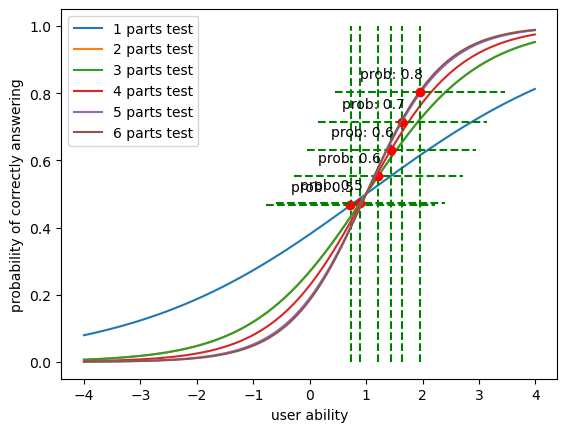

In [19]:
print(all_selected_diff)
print(all_whole_abilities)
all_selected_diff = all_selected_diff

if len(np.array(all_selected_diff).shape) == 2:
    diff=[]
    disc=[]
    for i in all_selected_diff:
        a = list(i)
        diff.append(a[1])
        disc.append(a[0])

if len(np.array(all_selected_diff).shape) == 1:
    diff = all_selected_diff
    disc = [1]*len(diff)
    
guess = [0]*len(diff)
plot_ICC(diff=diff, disc=disc, guess=guess, ability=all_whole_abilities)

15.999999999999998


,final score,total score,user correct rate,user part ability,ability rate,user score rate
part.1,36.82,36.82,1.00,0.726075,0.621012,0.082835
part.2,39.84,79.68,0.50,0.899089,0.649848,0.172463
part.3,59.76,79.68,0.75,1.217703,0.702951,0.306907
part.4,61.08,81.44,0.75,1.447587,0.741264,0.444319
part.5,62.46,83.28,0.75,1.639919,0.773320,0.584837
part.6,83.60,83.60,1.00,1.952976,0.825496,0.772913


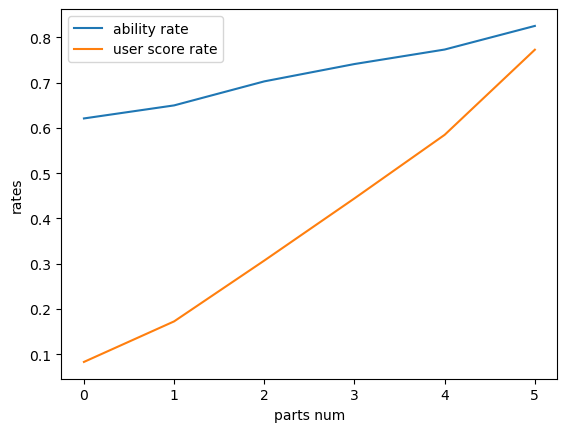

In [20]:
question_score, material_score = getQuestionsScore(quesDiff)
print(material_score[10242])
final_score = 0
total_score = 0

part_final_score = 0
part_total_score = 0

parts_final_score = []
parts_total_score = []
parts_user_score = []
ability_rate = []

part_flag = 0
for ans, item in zip(correct_rate, all_selected_items):

    part_final_score = part_final_score + (material_score[item]*len(question_score[item])*ans)
#     final_score = final_score + material_score[item]
    
    part_total_score = part_total_score + (material_score[item]*len(question_score[item]))
    total_score = total_score + (material_score[item]*len(question_score[item]))
    
    part_flag += 1

    if part_flag == 2:
        parts_final_score.append(part_final_score)
        parts_total_score.append(part_total_score)
        parts_user_score.append(part_final_score / part_total_score)

        part_final_score = 0
        part_total_score = 0

        part_flag = 0    
    
# parts_final_score.append(final_score)
# parts_total_score.append(total_score)
# parts_user_score.append(final_score / total_score)

rowname = []
user_score_rate = []
for i, one_ability in enumerate(all_whole_abilities):
    name = "part."+ str(i+1)
    rowname.append(name)
    
    ability_rate.append((one_ability+3) / 6)
    user_score_rate.append(sum(parts_final_score[:i+1]) / total_score)
    
    
score_distribution = pd.DataFrame({"final score": parts_final_score,
                                   "total score": parts_total_score,
                                   "user correct rate":parts_user_score,
                                   "user part ability": all_whole_abilities,
                                   "ability rate": ability_rate,
                                   "user score rate": user_score_rate
                                  },index=rowname)

display(score_distribution)

x = range(len(all_whole_abilities))
y_score = user_score_rate
y_ability = ability_rate
plt.plot(x, y_ability, label='ability rate')
plt.plot(x, y_score, label='user score rate')
plt.xlabel('parts num')
plt.ylabel('rates')
plt.legend()

In [21]:
def NNtest(xtrain, ytrain, xtest, lr, decay):
    
    xtrain = np.array(xtrain.values)
    xtest = xtest.values
    ytrain = np.array(ytrain)
    ytrain_0_1 = []
    i_0_1 = []
    for i,y in enumerate(ytrain):
        if y < 0.74:
            ytrain_0_1.append(0)
        else:
            i_0_1.append(i)
#             ytrain_0_1.append(1)
    xtrain_0_1 = np.delete(xtrain, i_0_1, axis=0)
    input_shape = [xtrain.shape[1]]
    model = Sequential([
        Dense(units=32, activation='relu', input_shape=input_shape),
        Dense(units=16, activation='relu'),
        Dense(units=2, activation='softmax')
    ])
    
    adam = Adam(learning_rate = lr, decay = decay)

    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
    
    model.fit(xtrain_0_1, np.array(ytrain_0_1))
    
    result_probs = model.predict(xtest)
    return result_probs

In [38]:
def DecisionTreeRegressionTest(xtrain, ytrain, xtest, depth):
    ytrain_0_1 = []
    xtrain_0_1 = []
    i_0_1 = []
    dt = DecisionTreeClassifier(max_depth=depth)
    
    for i,y in enumerate(ytrain):
        if y < 0.74:
            ytrain_0_1.append(0)  
        else:
            i_0_1.append(i)
        #    ytrain_0_1.append(1)
    
    xtrain_0_1 = np.delete(np.array(xtrain), i_0_1, axis=0)
    dt_model = dt.fit(xtrain_0_1, ytrain_0_1)
    y_predict_prob = dt_model.predict_proba(xtest)
    y_predict_label = dt_model.predict(xtest)
    return dt_model, y_predict_prob

In [49]:
def getRecommendationQuestions(material_feature_path, matDiffPath, dataf, correct_rate, all_selected_items, ability, n_expectations):

    matDiff = pd.read_csv(matDiffPath)
    
    quesDiff = getQuestionsDifficulty(dataf, list(matDiff['Materials Difficulty']))
    for i in all_selected_items:
        quesDiff.pop(i)
    
    matDiff = matDiff.drop(index = all_selected_items)
    print(len(quesDiff))
    
    material_features = loadMaterialsFeaturesForML(material_feature_path)
    Xtrain = material_features.iloc[all_selected_items]
    Xtrain=Xtrain[["Materials Difficulty", "Questions Numbers", "Topics"]]
    Xtest = material_features.drop(index = all_selected_items)
    Xtest=Xtest[["Materials Difficulty", "Questions Numbers", "Topics"]]
    print(Xtest.shape)
    question_score, material_score = getQuestionsScore(quesDiff)
    print(len(material_score))
    probs_distribution = getProbOfQuestions(ability=ability, CandidateMaterialsDifficultyLevel=list(matDiff['Materials Difficulty']))

#     lr_model, predict_probs = Logistic_Regression(xtrain=Xtrain, ytrain=correct_rate, xtest=Xtest)
    dt_model, predict_probs = DecisionTreeRegressionTest(xtrain=Xtrain, ytrain=correct_rate, xtest=Xtest, depth=4)
    predict_probs=NNtest(xtrain=Xtrain, ytrain=correct_rate, xtest=Xtest, lr=1e-6, decay=1e-2)
    
    top_n_questions = Max_N_Expectation(scores=material_score, questions_probs=probs_distribution, 
                                    posterior_probs=predict_probs, n_expectatios=n_expectations)

    Questions, Choices, TrueAnswers, OutputPath = data_to_GUI(top_n_questions)
    return Questions, Choices, TrueAnswers, OutputPath, top_n_questions

In [50]:
material_feature_path = "Data/Material Features For ML/Material_Features_For_ML.csv"
matDiffPath = "Data/Diffculty Level/Mateials_diffculty_by_cluster.csv"
Questions, Choices, TrueAnswers, OutputPath, top_n_questions_index = getRecommendationQuestions(material_feature_path=material_feature_path, 
                                                                         matDiffPath=matDiffPath, dataf=Data, 
                                                                         correct_rate=correct_rate, 
                                                                         all_selected_items=all_selected_items, 
                                                                         ability=whole_ability, 
                                                                         n_expectations=5)

# app = ListeningComprehensionApp(manyQuestions=Questions, manyChoices=Choices, 
#                                 manyTrueAnswers=TrueAnswers, manyOutputPath=OutputPath, Recommendation=True, LastPart=False)
# app.mainloop()

12447it [00:00, 950211.17it/s]


12435
(12435, 3)
12435
389/389 [==============================] - 0s 793us/step
MoviePy - Writing audio in Data/Conversation mp3/index9705.mp3


MoviePy - Done.
MoviePy - Writing audio in Data/Conversation mp3/index7186.mp3


MoviePy - Done.


MoviePy - Writing audio in Data/Conversation mp3/index6557.mp3


MoviePy - Done.
MoviePy - Writing audio in Data/Conversation mp3/index37.mp3


MoviePy - Done.
MoviePy - Writing audio in Data/Conversation mp3/index7206.mp3


MoviePy - Done.


In [51]:
def get_similarity(selected_items_index, reocmmendation_items_index, material_features_path):
    
    material_features = loadMaterialsFeaturesForML(material_feature_path)
    
    selected_items = material_features.iloc[selected_items_index]
    recommendation_items = material_features.iloc[reocmmendation_items_index]
    
    selected_items['type'] = ['test']*selected_items.shape[0]
    recommendation_items['type'] = ['recommendation']*len(recommendation_items.index)
    
    min_distance = []
    max_distance = []
    closest_index = []
    farest_index = []
    for selected_row in selected_items[["Materials Difficulty", "Questions Numbers", "Topics"]].values:
        temp_distance = []
        for recom_row in recommendation_items[["Materials Difficulty", "Questions Numbers", "Topics"]].values:
            temp_distance.append(np.dot(selected_row, recom_row)/(norm(selected_row)*norm(recom_row)))
        min_distance.append(min(temp_distance))
        closest_index.append(recommendation_items['Material Index'].iloc[np.argmin(temp_distance)])
        max_distance.append(max(temp_distance))
        farest_index.append(recommendation_items['Material Index'].iloc[np.argmax(temp_distance)])        
    selected_items["min_similarity"] = min_distance
    selected_items["closest_index"] = closest_index
    selected_items["max_similarity"] = max_distance
    selected_items["farest_index"] = farest_index    
    
    
    min_distance = []
    max_distance = []
    closest_index = []
    farest_index = []
    for recom_row in recommendation_items[["Materials Difficulty", "Questions Numbers", "Topics"]].values:
        temp_distance = []
        for selected_row in selected_items[["Materials Difficulty", "Questions Numbers", "Topics"]].values:
            temp_distance.append(np.dot(selected_row, recom_row)/(norm(selected_row)*norm(recom_row)))
        min_distance.append(min(temp_distance))
        closest_index.append(selected_items['Material Index'].iloc[np.argmin(temp_distance)])
        max_distance.append(max(temp_distance))
        farest_index.append(selected_items['Material Index'].iloc[np.argmax(temp_distance)])         
    recommendation_items["min_similarity"] = min_distance
    recommendation_items["closest_index"] = closest_index    
    recommendation_items["max_similarity"] = max_distance
    recommendation_items["farest_index"] = farest_index    
            
    print(selected_items[["Materials Difficulty", "Questions Numbers", "Topics"]].values)
    recommendation_items[["Materials Difficulty", "Questions Numbers", "Topics"]].values
    
    selected_recomm_items = pd.concat([selected_items, recommendation_items])
    
#     display(selected_items)
#     display(recommendation_items)
    display(selected_recomm_items)
    

In [52]:
item_sele = []
for co, item_index in zip(correct_rate, all_selected_items):
    if co < 0.74:
        item_sele.append(item_index)

get_similarity(selected_items_index=item_sele,
               reocmmendation_items_index=top_n_questions_index, 
               material_features_path=material_feature_path)

[[1.   2.   4.  ]
 [1.   2.   0.  ]
 [1.   2.   2.  ]
 [1.22 2.   4.  ]
 [1.45 2.   2.  ]]


,Unnamed: 0,Material Index,Materials Difficulty,Questions Numbers,Topics,type,min_similarity,closest_index,max_similarity,farest_index
11945,11945,11945,1.00,2,4,test,0.487764,6557,0.998508,9705
2170,2170,2170,1.00,2,0,test,0.018870,7206,0.999619,6557
5064,5064,5064,1.00,2,2,test,0.606276,7206,0.999940,37
8841,8841,8841,1.22,2,4,test,0.504577,6557,0.999966,9705
7986,7986,7986,1.45,2,2,test,0.515329,7206,0.992454,37
9705,9705,9705,1.26,2,4,recommendation,0.506289,2170,0.999966,8841
7186,7186,7186,-0.64,1,3,recommendation,0.188511,2170,0.903607,11945
6557,6557,6557,1.07,2,0,recommendation,0.487764,11945,0.999619,2170
37,37,37,2.07,4,4,recommendation,0.747621,2170,0.999940,5064
7206,7206,7206,-1.81,1,4,recommendation,0.018870,2170,0.784594,11945
